**Import the require library**

pip install os<br/>
pip install mne<br/>
pip install numpy<br/>
pip install scipy<br/>
pip install matplotlib<br/>

In [216]:
import mne
import warnings
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
from Functions import Data_path, Plot_data, Filtering, FFT, Common_average_reference

**Step 1.1: Importing pathway files**

In [182]:
folder_path = "D:\GitHub\SSVEP-based-EEG-signal-processing\Data" # Define the base folder path where the data is located
path_files, files, folders = Data_path.data_path(folder_path, data_format="gdf") 
path_files

['D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.27.02].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.36.29].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.44.23].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.57.52].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.17.50].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.27.18].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.45.34].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.53.10].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.06.48].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.19.25].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.2

**Step 1.2: Load data, channel locations, labels & events**<br/>
Label_01 ---> 13Hz stimulation (33025)<br/>
Label_02 ---> 21Hz stimulation (33026)<br/>
Label_03 ---> 17Hz stimulation (33027)<br/>
Rest ---> 33024

In [183]:
warnings.filterwarnings("ignore", message="Omitted .* annotation.*")
raw = mne.io.read_raw_gdf(path_files[0], verbose=0)  # Read the data from the GDF file into a raw MNE object
channels_name = raw.ch_names                          # Extract the channel names from the raw data
data = raw.get_data().T                               # Get the EEG data and transpose it to have channels as rows and samples as columns
fs = raw.info['sfreq']                                # Get the sampling frequency of the EEG data
labels = raw.annotations.description                  # Define labels for each stimulation frequency
events, event_ind = mne.events_from_annotations(raw, verbose=0)  # Get the start time of each trial from the annotations

In [5]:
print(f"data: {data}, \n channels_name: {channels_name}, \n labels: {labels}, \n events: {events}, \n event_ind:{event_ind}")

data: [[ 1.17396582e-08 -4.74957048e-09 -1.26818539e-08 ...  3.03539815e-09
   1.22814473e-08  8.15642478e-09]
 [ 2.38604741e-08  5.03880715e-09 -1.56107228e-09 ...  1.22761669e-08
   2.10623854e-08  1.36445768e-08]
 [ 5.39719351e-09 -5.26715188e-09 -7.16606514e-09 ... -3.61855346e-09
   3.91582377e-09  3.01696753e-09]
 ...
 [ 1.56274671e-08  1.21936088e-08 -7.98376966e-09 ...  5.87641119e-09
   8.58811349e-09  7.09517992e-09]
 [-2.10399069e-09 -6.85034204e-10 -1.61905497e-08 ... -1.11846198e-08
  -7.72781887e-09 -8.94477811e-10]
 [-2.48514842e-09 -4.88657732e-09 -1.41685894e-08 ... -1.23060723e-08
  -4.01965243e-09  2.59246959e-09]], 
 channels_name: ['Oz', 'O1', 'O2', 'PO3', 'POz', 'PO7', 'PO8', 'PO4'], 
 labels: ['32769' '33024' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33026' '32779' '32780' '33025' '32779'
 '32780' '33024' '32779' '32780' '33027' '32779' '32780' '33025' '32779'
 '32780' '33026' '32779' '32780' '33027' '32779' '32780'

**Step 2.1: Split trials for a single dataset** **(** *e.g., Subject2-[2012.04.07-19.27.02].gdf* **)**

In [184]:
time_trial = 5                          # Define the duration of each trial in seconds
time_start_trial = events[:, 0]         # Extract the start time of each trial from the events                   
duration_trial = int(fs * time_trial)   # Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)
lab = ['33025', '33026', '33027']       # Define the labels for the current iteration

for i in range(3):                      # Loop through the labels of interest
    num_trials = np.where(labels == lab[i])[0] # Find the indices of trials with the current label
    # Initialize an array to store trial data for the current label
    data_trial = np.zeros((duration_trial, len(channels_name), len(num_trials))) 
    for j, trial_index in enumerate(num_trials): # Iterate over each trial index and extract the corresponding data
        data_trial[:, :, j] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + duration_trial, :]
    exec(f'data_trial_{i + 1} = data_trial')    # Using exec to dynamically create variable names for each trial's data array

print(f"data_trial_1: {data_trial_1.shape} \ndata_trial_2: {data_trial_2.shape} \ndata_trial_3: {data_trial_3.shape}")

data_trial_1: (1280, 8, 10) 
data_trial_2: (1280, 8, 10) 
data_trial_3: (1280, 8, 10)


**Step 2.2: Split trials for all datasets**

In [218]:
data1, data2, data3 = [], [], []
lab = ['33025', '33026', '33027']       # Define the labels for the current iteration
duration_trial = int(fs * time_trial)   # Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)
data_list = [data1, data2, data3]  # Initialize a list to store data lists

for i in range(len(path_files)):
    raw = mne.io.read_raw_gdf(path_files[i], verbose=0) # Read the data from the GDF file into a raw MNE object
    data = raw.get_data().T                             # Get the EEG data and transpose it to have channels as rows and samples as columns
    labels = raw.annotations.description                # Define labels for each stimulation frequency
    events, _ = mne.events_from_annotations(raw, verbose=0) # Get the start time of each trial from the annotations
    time_start_trial = events[:, 0]                     # Extract the start time of each trial from the events 
    
    for j in range(3):                                # Loop through the labels of interest
        num_trials = np.where(labels == lab[j])[0]    # Find the indices of trials with the current label
        # Initialize an array to store trial data for the current label
        data_trial = np.zeros((duration_trial, len(channels_name), len(num_trials))) 

        for ind, trial_index in enumerate(num_trials):  # Iterate over each trial index and extract the corresponding data
            data_trial[:, :, ind] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + duration_trial, :]
        
        # Append data_trial to the corresponding list based on the value of j
        data_list[j].append(data_trial)
        
# Concatenate the lists of data arrays along the third axis
data1 = np.concatenate(data1, axis=2)
data2 = np.concatenate(data2, axis=2)
data3 = np.concatenate(data3, axis=2)

print(f"data1.shape: {data1.shape} \ndata2.shape: {data2.shape} \ndata3.shape: {data3.shape}")

data1.shape: (1280, 8, 160) 
data2.shape: (1280, 8, 160) 
data3.shape: (1280, 8, 160)


**Step 2.3: Plot data (** *Plot a trial for one of the stimulation frequencies* **)**<br/>

*Input parameters:*
 - `data:` EEG data to be plotted
 - `fs:` Sampling frequency of the EEG data
 - `channels:` Names of the EEG channels
 - `first_point:` Index of the first data point to plot (optional, defaults to 0)
 - `last_point: `Index of the last data point to plot (optional, defaults to 3000)
 - `val_ylim:` Maximum absolute y-axis limit for the plot (optional, defaults to 2.7)
 - `size_fig:` Size of the figure (optional, defaults to (5, 5))
 - `title:` Title of the plot (optional, defaults to 'Raw data')
 - `display_figure:` Whether to display the figure ('on' or 'off') (optional, defaults to 'on')

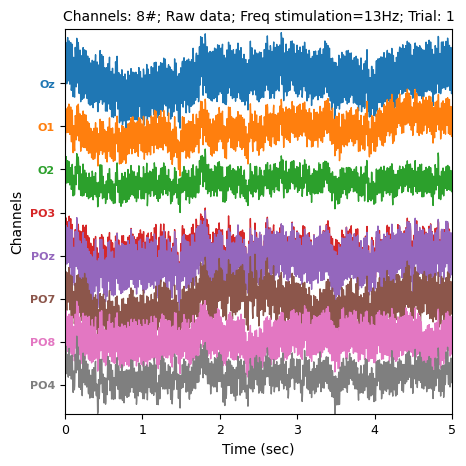

In [221]:
trial = 1
freq_stim = 13
title = f'Raw data; Freq stimulation={13}Hz; Trial: {trial}'
Plot_data.plot_data(data1[:, :, trial-1], fs, channels_name, first_point=0, last_point=1280, val_ylim=2.7, size_fig=(5,5), title=title, 
                    display_figure="on")  # Plot EEG data using the Plot_data.plot_data function

In [235]:
reload(Filtering)

<module 'Functions.Filtering' from 'd:\\GitHub\\SSVEP-based-EEG-signal-processing\\Code\\Python\\Functions\\Filtering.py'>

**Step 2.3: Filtering (** *Filter a trial for one of the stimulation frequencies* **)**<br/>

*Input parameters:*
 - `data:` EEG data to be filtered
 - `f_low:` Lower cutoff frequency of the bandpass filter
 - `f_high:` Upper cutoff frequency of the bandpass filter
 - `order:` Filter order
 - `fs:` Sampling frequency of the EEG data (optional, if not provided, it is assumed to be fs)
 - `type_filter:` Type of filter ('low', 'high', 'bandpass', or 'bandstop') (optional, defaults to 'bandpass')
 - `filter_active:` Filter data using a specific type of filter ('low', 'high', 'bandpass', or 'bandstop') (optional, defaults to 'on')

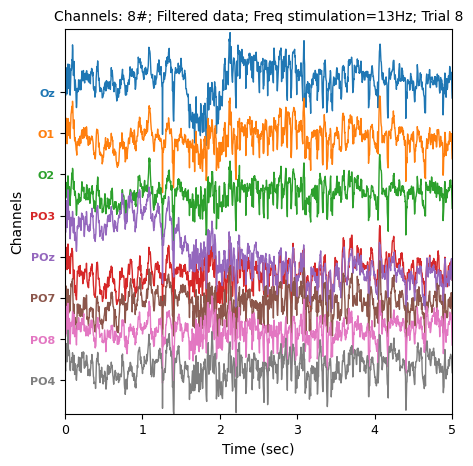

In [236]:
# Define parameters for filtering
trial = 8
order = 5
f_low = 0.05
f_high = 100
notch_freq = 50      # Frequency to be removed from signal (Hz)
quality_factor = 20  # Quality factor for notch filter
title = f'Filtered data; Freq stimulation=13Hz; Trial {trial}'
# Apply bandpass filtering to the EEG data using the Filtering.filtering function
data_filtered = Filtering.filtering(data1, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active="off", notch_filter="on", 
                                    type_filter='bandpass')
Plot_data.plot_data(data_filtered[:, :, trial-1], fs, channels_name, first_point=0, last_point=1280, val_ylim=2.7, size_fig=(5,5), title=title, 
                    display_figure="on")

**Step 3: Fourier transform for a channel**

In [225]:
reload(FFT)

<module 'Functions.FFT' from 'd:\\GitHub\\SSVEP-based-EEG-signal-processing\\Code\\Python\\Functions\\FFT.py'>

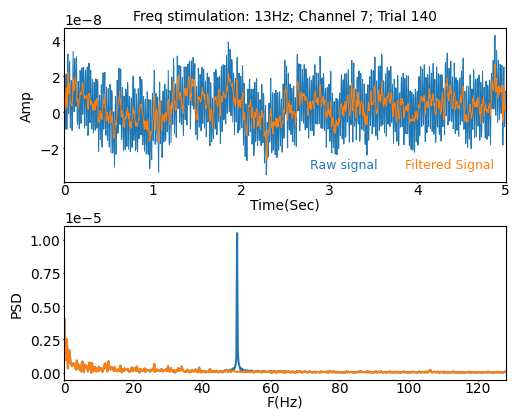

In [226]:
trial = 140     # for data with shape (samples, channels, trials)
channel = 7
title = f"Freq stimulation: {13}Hz; Channel {channel}; Trial {trial}"
FFT.fft(data1, data_filtered, fs, channel, trial, title, size_fig=[5, 4])

In [117]:
data = data1
data_filtered = np.zeros((160, 8, 1280))

In [121]:
fs

256.0

In [122]:
from scipy import signal
notch_freq = 50      # Frequency to be removed from signal (Hz)
quality_factor = 5 # Quality factor for notch filter
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, 256)
if (data.ndim == 2 and data.shape[0] > data.shape[1]) or (data.ndim == 3 and data.shape[0] > data.shape[2]):
        data = data.T
        
for i in range(data.shape[0]):
    data_filtered[i, :, :] = signal.filtfilt(b_notch, a_notch, data[i, :, :])

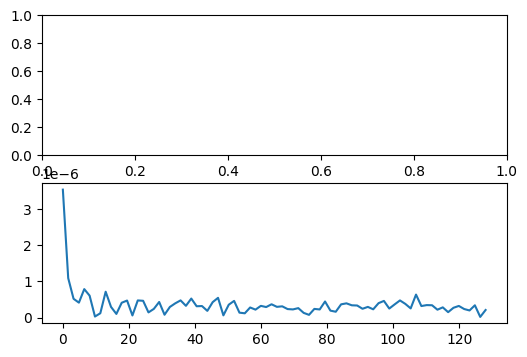

In [123]:
trial = 0      # for data with shape (samples, channels, trials)
channel = 0
_, axs = plt.subplots(nrows=2, sharey="row", figsize=[6,4]) # Create subplots for the figure
time = (np.linspace(start=0, stop=len(data)/fs, num=len(data))).flatten()
x_fft = np.fft.fft(data[:, channel, trial])
x_filter_fft = np.fft.fft(data_filtered[:, channel, trial])
x_psd = np.abs(x_fft[:len(x_fft)//2])                           # Calculate the one-sided power spectral density (PSD)
x_filter_psd = np.abs(x_filter_fft[:len(x_filter_fft)//2])
f = np.linspace(0, fs/2, len(x_fft)//2)                         # Create a frequency axis
# ------------------------------------------ Plot Result  --------------------------------------------
x_psd = np.abs(x_fft[:len(x_fft)//2])                           # Calculate the one-sided power spectral density (PSD)
x_filter_psd = np.abs(x_filter_fft[:len(x_filter_fft)//2])
f = np.linspace(0, fs/2, len(x_fft)//2)                         # Create a frequency axis
axs[1].plot(f, x_psd)
# axs[1].plot(f, x_filter_psd)

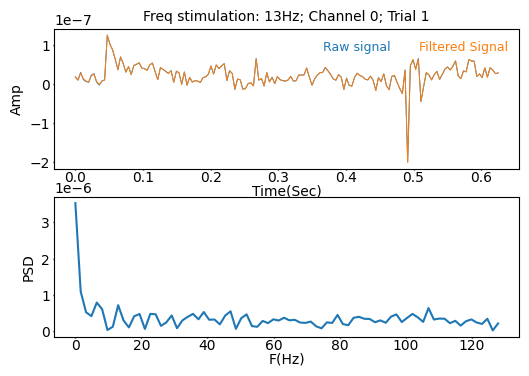

In [111]:
trial = 0      # for data with shape (samples, channels, trials)
channel = 0
_, axs = plt.subplots(nrows=2, sharey="row", figsize=[6,4]) # Create subplots for the figure
time = (np.linspace(start=0, stop=len(data)/fs, num=len(data))).flatten()
# ------------------- Perform Fourier transform on the ith trial's single channel --------------------
if data.ndim == 3:
    x_fft = np.fft.fft(data[:, channel, trial])
    x_filter_fft = np.fft.fft(data_filtered[:, channel, trial]) # Perform Fourier transform on the filtered signal
    axs[0].plot(time, data[:, channel, trial], linewidth=0.7, label="Raw signal")
    axs[0].plot(time, data_filtered[:, channel, trial], linewidth=0.7, label="Filtered Signal")
elif data.ndim ==2:
    x_fft = np.fft.fft(data[:, channel])
    x_filter_fft = np.fft.fft(data_filtered[:, channel])        # Perform Fourier transform on the filtered signal
    axs[0].plot(time, data[:, channel], linewidth=0.7, label="Raw signal")
    axs[0].plot(time, data_filtered[:, channel], linewidth=0.7, label="Filtered Signal")
else:
    x_fft = np.fft.fft(data)
    x_filter_fft = np.fft.fft(data_filtered)                    # Perform Fourier transform on the filtered signal
    axs[0].plot(time, data, linewidth=0.7, label="Raw signal")
    axs[0].plot(time, data_filtered, linewidth=0.7, label="Filtered Signal")

x_psd = np.abs(x_fft[:len(x_fft)//2])                           # Calculate the one-sided power spectral density (PSD)
x_filter_psd = np.abs(x_filter_fft[:len(x_filter_fft)//2])
f = np.linspace(0, fs/2, len(x_fft)//2)                         # Create a frequency axis
# ------------------------------------------ Plot Result  --------------------------------------------
axs[1].plot(f, x_psd)
# axs[1].plot(f, x_filter_psd)
axs[0].set_ylabel('Amp', fontsize=10)
axs[1].set_ylabel('PSD', fontsize=10)
axs[0].set_title(title, fontsize=10)
axs[1].set_xlabel('F(Hz)', labelpad=-0.1, fontsize=10)
axs[0].set_xlabel('Time(Sec)', labelpad=-0.1, fontsize=10)
# axs[0].autoscale(enable=True, axis="x",tight=True) # Auto-scale x-axis and set y-axis limits
# axs[1].autoscale(enable=True, axis="x",tight=True) 
axs[0].legend(fontsize=9, ncol=2, handlelength=0, handletextpad=0.25, frameon=False, labelcolor='linecolor')
axs[0].tick_params(axis='x', length=1, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0)
axs[1].tick_params(axis='x', length=1, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0)
axs[0].tick_params(axis='y', length=1, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=2)
axs[1].tick_params(axis='y', length=1, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=2)
# plt.tight_layout(pad=0, h_pad=0, w_pad=0); # fig.subplots_adjust(wspace=0, hspace=0), 

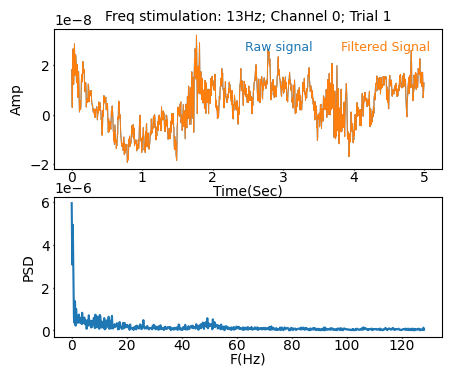

In [87]:
trial = 1      # for data with shape (samples, channels, trials)
channel = 0
title = f"Freq stimulation: {13}Hz; Channel {channel}; Trial {trial}"
FFT.fft_(data1, data_filtered, fs, channel, trial, title, size_fig=[5, 4])

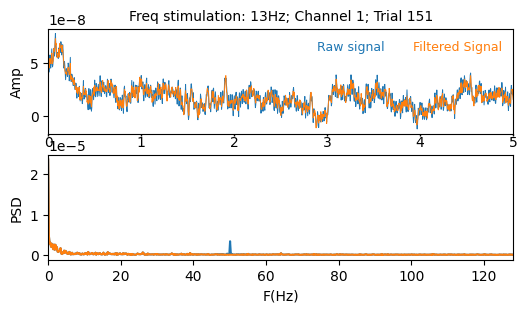

In [84]:
import matplotlib.pyplot as plt

# Create subplots for the figure
fig, axs = plt.subplots(nrows=2, sharex="row", sharey="row", figsize=size_fig)

# Calculate time axis
time = np.linspace(start=0, stop=len(data)/fs, num=len(data))

# Plot raw and filtered signals against time in the first row
axs[0].plot(time, data[:, channel, trial], linewidth=0.7, label="Raw signal")
axs[0].plot(time, data_filtered[:, channel, trial], linewidth=0.7, label="Filtered Signal")

# Perform Fourier transform on the signals and plot PSD in the second row
x_fft = np.fft.fft(data[:, channel, trial])
x_filter_fft = np.fft.fft(data_filtered[:, channel, trial])
x_psd = np.abs(x_fft[:len(x_fft)//2])
x_filter_psd = np.abs(x_filter_fft[:len(x_filter_fft)//2])
f = np.linspace(0, fs/2, len(x_fft)//2)

axs[1].plot(f, x_psd, label='Raw PSD')
axs[1].plot(f, x_filter_psd, label='Filtered PSD')

# Set labels, titles, legends, and autoscale axes
axs[0].set_ylabel('Amp', fontsize=10)
axs[1].set_ylabel('PSD', fontsize=10)
axs[0].set_title(title, fontsize=10)
axs[1].set_xlabel('F(Hz)', fontsize=10)
axs[0].set_xlabel('Time(Sec)', fontsize=10)
axs[0].autoscale(enable=True, axis="x",tight=True) # Auto-scale x-axis and set y-axis limits
axs[1].autoscale(enable=True, axis="x",tight=True) 
axs[0].legend(fontsize=9, ncol=2, handlelength=0, handletextpad=0.25, frameon=False, labelcolor='linecolor')
axs[0].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0)

plt.show()


In [37]:
x_psd.shape

(640,)

**Step 1.4: CAR filter**

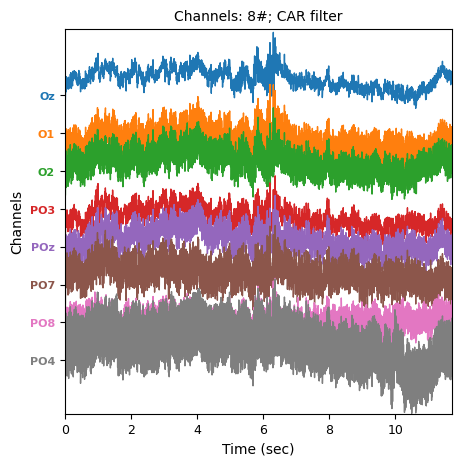

In [25]:
data_car = Common_average_reference.car(data_filtered[:,:,1]) # Apply common average reference (CAR) to the EEG data using the Common_average_reference.car function
Plot_data.plot_data(data, fs, channels_name, first_point=0, last_point=3000, val_ylim=2.7, size_fig=(5,5), title='CAR filter', 
                    display_figure="on")

**Step 3: CCA Method**

In [ ]:
x = data_trial_1[:,:,1]           # (number samples, number channel, number trials)
num_harmonic = 2                  # Number of harmonic for each frequency stimulation
num_channel = [1, 4]              # Number of Channel
f_stim = [13, 21, 17]             # Freqquencies stimuation
num_sample_neigh = 20             # Number of samples neighborhood for each frequency stimulation
num_samples_trial = int(fs * duration_trial)            
time = np.linspace(0, duration_trial, num_samples_trial)  # Time vector

f_low, f_high, order = 5, 50, 3    # Define filter parameters
data = Filtering.filtering(x, f_low, f_high, order, fs, type_filter='bandstop') # Apply bandstop filtering to the EEG data 

f_high, order = min(f_stim) - 1, 3    # Define filter parameters
data = Filtering.filtering(x, f_low, f_high, order, fs, type_filter='high') # Apply high filtering to the EEG data 

In [55]:
from scipy.linalg import canoncorr
f_ref = np.zeros(len(f_stim))
for i in range(len(f_stim)):  # First loop for frequencies stimulation
    data_ref = np.zeros((len(time), 2 * num_harmonic))
    for j in range(num_harmonic):  # Second loop creates a reference signal for each frequency stimulation
        signal_ref = np.zeros((len(time), 2))
        signal_ref[:, 0] = np.sin(2 * np.pi * (j + 1) * f_stim[i] * time)
        signal_ref[:, 1] = np.cos(2 * np.pi * (j + 1) * f_stim[i] * time)
        data_ref[:, j * 2:(j + 1) * 2] = signal_ref
    _, _, a = canoncorr(data[:, num_channel], data_ref)
    f_ref[i] = np.max(a)
label_predic = np.argmax(f_ref)

ImportError: cannot import name 'canoncorr' from 'scipy.linalg' (c:\Users\RezaS\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\__init__.py)